##### 01 - Explore FashionLabels and apply shared normalization

This notebook loads the FashionLabels workbook, checks what columns and label values we have, and applies the same `normalize_text` function to the product names so they can later be joined to the JSON data.

##### Find project root and import project modules

This cell searches upward for the folder that contains the `src` directory, adds it to Python's import path, and then imports the config and text normalization function.

In [2]:
from pathlib import Path
import sys

# Start from the current working directory and walk up
cwd = Path.cwd()
project_root = None

for path in [cwd, *cwd.parents]:
    if (path / "src").is_dir():
        project_root = path
        break

if project_root is None:
    raise FileNotFoundError(
        "Could not find a folder containing 'src'. "
        "Please make sure you are working inside the PRODUCT-CLASSIFCATION project."
    )

SRC_DIR = project_root / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from config import (
    PROJECT_ROOT as CFG_PROJECT_ROOT,
    LABELS_DIR,
)
from preprocessing import normalize_text

CFG_PROJECT_ROOT, LABELS_DIR

(PosixPath('/Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation'),
 PosixPath('/Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/labels'))

##### Load the FashionLabels workbook

This cell reads the FashionLabels Excel file from the labels folder and shows the first few rows so we can inspect the raw columns and label values.

In [3]:
import pandas as pd

labels_path = LABELS_DIR / "FashionLabels.xlsm"
print("Labels file path:", labels_path)

if not labels_path.is_file():
    raise FileNotFoundError(f"Could not find FashionLabels.xlsm at {labels_path}")

labels_df = pd.read_excel(labels_path)

labels_df.head()

Labels file path: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/labels/FashionLabels.xlsm


,product_name,count,relevant_code
0,"molshine Hard Shell Sunglasses Case,Classic La...",312,0
1,"AstroAI Car Jump Starter, 2000A 12V 8-in-1 Bat...",274,0
2,"molshine Hard Shell Sunglasses Case,Classic La...",180,0
3,"N&ampT NIETING Burlap Christmas Tree Skirt, 30...",96,0
4,NaN,90,0


In [6]:
# Check raw label values
labels_df["relevant_code"].value_counts(dropna=False)

# Keep only the columns we care about
labels_clean = labels_df[["product_name", "relevant_code"]].copy()

# Drop rows where product_name is missing
labels_clean = labels_clean.dropna(subset=["product_name"])

# Map raw codes to binary labels: 1 -> 1 (fashion), everything else -> 0 (non-fashion)
labels_clean["label_raw"] = labels_clean["relevant_code"]
labels_clean["label"] = (labels_clean["label_raw"] == 1).astype(int)

# Add raw and normalized text columns for clarity
labels_clean["product_text_raw"] = labels_clean["product_name"]
labels_clean["product_text_norm"] = labels_clean["product_text_raw"].apply(normalize_text)

# Show a sample of the cleaned labels
labels_clean[["product_text_raw", "product_text_norm", "label_raw", "label"]].head(10)

,product_text_raw,product_text_norm,label_raw,label
0,"molshine Hard Shell Sunglasses Case,Classic La...",molshine hard shell sunglasses case classic la...,0,0
1,"AstroAI Car Jump Starter, 2000A 12V 8-in-1 Bat...",astroai car jump starter 2000a 12v 8 in 1 batt...,0,0
2,"molshine Hard Shell Sunglasses Case,Classic La...",molshine hard shell sunglasses case classic la...,0,0
3,"N&ampT NIETING Burlap Christmas Tree Skirt, 30...",n ampt nieting burlap christmas tree skirt 30 ...,0,0
5,Vemiss Hard Shell Eyeglasses Case Linen Fabric...,vemiss hard shell eyeglasses case linen fabric...,0,0
7,POPRUN 2024 Pocket Calendar (3.5'' x 6.5'')202...,poprun 2024 pocket calendar 3 5 x 6 5 2024 poc...,0,0
8,Amazon.com - DWVO Farmhouse Coffee Bar Cabinet...,amazon com dwvo farmhouse coffee bar cabinet 3...,0,0
9,Twinkle Star Set of 3 Christmas Lighted Gift B...,twinkle star set of 3 christmas lighted gift b...,0,0
10,Amazon.com - X-cosrack Coffee Bar Cabinetï¼Œ3 ...,amazon com x cosrack coffee bar cabineti1 4 3 ...,0,0
12,"Mini Retro Hinges, OZXNO 8 PCS Rectangle Antiq...",mini retro hinges ozxno 8 pcs rectangle antiqu...,0,0


##### Check label distribution with counts and percentages and a simple bar chart

Raw label codes (relevant_code):
label_raw
0      93910
1     397879
10     62230
Name: count, dtype: int64

Binary labels (0=non-fashion, 1=fashion):
label=0: 156140 rows (28.18%)
label=1: 397879 rows (71.82%)


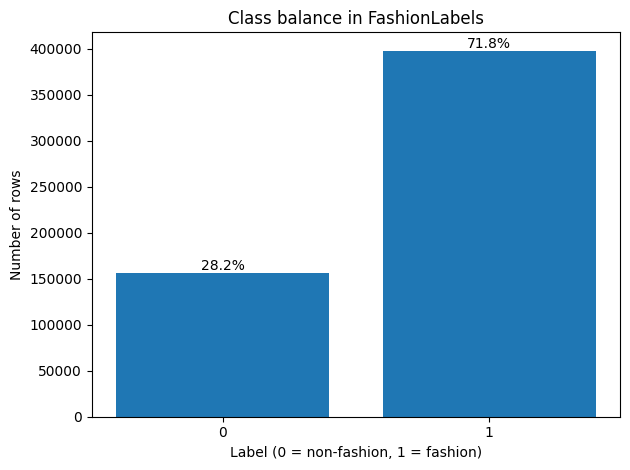

In [8]:
import matplotlib.pyplot as plt

# Count raw codes (0, 1, 10, etc.) to see what exists
raw_counts = labels_clean["label_raw"].value_counts(dropna=False).sort_index()
print("Raw label codes (relevant_code):")
print(raw_counts)
print()

# Count binary labels (0 = non-fashion, 1 = fashion) with percentages
bin_counts = labels_clean["label"].value_counts().sort_index()
bin_pct = labels_clean["label"].value_counts(normalize=True).sort_index() * 100

print("Binary labels (0=non-fashion, 1=fashion):")
for k in bin_counts.index:
    print(f"label={k}: {bin_counts[k]} rows ({bin_pct[k]:.2f}%)")

# Bar chart for binary class balance with percentage labels on bars
labels_list = bin_counts.index.astype(str).tolist()
values = bin_counts.values
pct_values = [bin_pct[k] for k in bin_counts.index]
x_pos = range(len(labels_list))

plt.figure()

bars = plt.bar(x_pos, values)

plt.xticks(x_pos, labels_list)
plt.xlabel("Label (0 = non-fashion, 1 = fashion)")
plt.ylabel("Number of rows")
plt.title("Class balance in FashionLabels")

# Add percentage labels above each bar
for x, height, pct in zip(x_pos, values, pct_values):
    plt.text(
        x,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom"
    )

# Do not display grid lines unless we explicitly need them
plt.grid(False)

plt.tight_layout()
plt.show()

#### From the chart above, it is clear that Our labeling process oversamples fashion items; the labeled dataset has ~72% fashion vs ~28% non-fashion, which differs from the real production mix where fashion is rare. This is a classic “sample selection / prior shift” situation (training distribution ≠ deployment distribution)

#### Here is what we can expect to see moving forwared : 	
-	Logistic regression learns probabilities consistent with the labeled data’s prior (72% fashion).
-   In real traffic where the true prior is, say, 5% fashion, those probabilities will be overconfident towards fashion unless we correct them or adjust thresholds.
-   The loss will be dominated by fashion examples; the model may treat non-fashion as “rare” and be more willing to misclassify them as fashion.
-   If we only test on this 72% fashion distribution, overall accuracy and even some metrics may overstate how well the model will behave in real traffic.

---------------------------------------------------------------------------------------------------------------------------------

##### Save clean labels and do a quick sanity check

In [9]:
# Save the cleaned labels table to data/processed for later use

from config import PROCESSED_DATA_DIR

# Make sure the processed folder exists
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

labels_clean_path = PROCESSED_DATA_DIR / "labels_clean.parquet"

labels_clean.to_parquet(labels_clean_path, index=False)

print("Saved cleaned labels to:", labels_clean_path)
print("Shape:", labels_clean.shape)

Saved cleaned labels to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/labels_clean.parquet
Shape: (554019, 6)


In [10]:
# Quick checks on labels_clean for later sanity

print("Rows in labels_clean:", len(labels_clean))
print("NaN labels:", labels_clean['label_raw'].isna().sum())
print("Empty normalized text:", (labels_clean['product_text_norm'] == "").sum())
print("Duplicate normalized names:", labels_clean['product_text_norm'].duplicated().sum())

Rows in labels_clean: 554019
NaN labels: 0
Empty normalized text: 0
Duplicate normalized names: 5465
